
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [2]:
!pip install transformers==4.33.1

  Obtaining dependency information for transformers==4.33.1 from https://files.pythonhosted.org/packages/13/30/54b59e73400df3de506ad8630284e9fd63f4b94f735423d55fc342181037/transformers-4.33.1-py3-none-any.whl.metadata
  Using cached transformers-4.33.1-py3-none-any.whl.metadata (119 kB)
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/5e/5d/97afbafd9d584ff1b45fcb354a479a3609bd97f912f8f1f6c563cb1fae21/filelock-3.12.4-py3-none-any.whl.metadata
  Obtaining dependency information for huggingface-hub<1.0,>=0.15.1 from https://files.pythonhosted.org/packages/50/9d/5eac2733606df7d164b951b14cd76b056e530af96c881aaec89383bdbe45/huggingface_hub-0.17.1-py3-none-any.whl.metadata
  Obtaining dependency information for numpy>=1.17 from https://files.pythonhosted.org/packages/71/3c/3b1981c6a1986adc9ee7db760c0c34ea5b14ac3da9ecfcf1ea2a4ec6c398/numpy-1.25.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information fo

In [19]:
import pandas as pd
import numpy as np
import torch

from tqdm import tqdm

from transformers import XLMRobertaTokenizerFast, XLMRobertaModel

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import csv
import ast

import matplotlib.pyplot as plt
import seaborn as sbn

In [12]:
df = pd.read_csv(f'../datasets/buscape_preprocessed.csv')

In [13]:
df.shape

(133438, 2)

In [14]:
df['rating'].value_counts()

rating
0    66741
1    66697
Name: count, dtype: int64

In [15]:
reviews = df['review_text']
labels = df['rating']

In [17]:
def load_model_on_cpu(model_path):
    # Load the model to CPU by using map_location
    loaded_model = torch.load(model_path, map_location=torch.device('cpu'))
    
    # Ensure all model parameters are on CPU
    if isinstance(loaded_model, torch.nn.Module):
        loaded_model.to(torch.device('cpu'))
    elif isinstance(loaded_model, dict):
        for key in loaded_model:
            if isinstance(loaded_model[key], torch.nn.Module):
                loaded_model[key].to(torch.device('cpu'))
    
    return loaded_model

In [20]:
loaded_embeddings_xml_roberta_large_buscape = []

with open('../embeddings/xml-roberta-large-embeddings-buscape.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in tqdm((reader),desc='Processing'):
        # Parse the string as a list and convert elements to floats
        embedding_list = ast.literal_eval(row[0])
        loaded_embeddings_xml_roberta_large_buscape.append(embedding_list)

Processing: 133438it [12:17, 180.90it/s]


In [24]:
print(f'Embeddings: {len(loaded_embeddings_xml_roberta_large_buscape)}')
print(f'Dimensions of each embedding: {len(loaded_embeddings_xml_roberta_large_buscape[0])}')

Embeddings: 133438
Dimensions of each embedding: 1024


In [25]:
embeddings_numpy_array = np.array(loaded_embeddings_xml_roberta_large_buscape)

In [27]:
embeddings_numpy_array.shape

(133438, 1024)

In [64]:
mean_values = np.mean(embeddings_numpy_array,axis=1)
min_values = np.min(embeddings_numpy_array,axis=1)
max_values = np.max(embeddings_numpy_array,axis=1)

In [65]:
mean_values = mean_values.reshape(-1, 1)  # Reshape to (num_samples, 1)
min_values = min_values.reshape(-1, 1)    # Reshape to (num_samples, 1)
max_values = max_values.reshape(-1, 1)    # Reshape to (num_samples, 1)

In [66]:
combined_data = np.concatenate((mean_values, min_values, max_values), axis=1)

In [67]:
combined_data.shape

(133438, 3)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(combined_data, labels, test_size=0.2, random_state=42)

In [71]:
DROPOUT = 0 #Dropout: 0, 10%
LEARNING_RATE = 2.5e-5 #Learning rate: 2.5e-5 e 5e-5
HIDDEN_LAYER = 24
INPUT_DIM = X_train.shape[1]
FOLDS = 10
EPOCHS = 5
BATCH_SIZE = 32
VERBOSE = 0
LOSS = 'binary_crossentropy'
METRICS = ['accuracy']
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=3)
CALLBACKS = [EARLY_STOP]

In [72]:
model = Sequential([
    Dense(
        HIDDEN_LAYER,
        activation='relu',
        input_dim=INPUT_DIM
    ),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 24)                96        
                                                                 
 dropout_6 (Dropout)         (None, 24)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 25        
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [73]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=LOSS,
    metrics=METRICS
)

In [74]:
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

In [75]:
fold = 0

losses = []
accuracies = []
f1_scores =[]
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

val_losses = []
val_accuracies = []
val_f1_scores = []
val_tprs = []
val_aucs = []
val_mean_fpr = np.linspace(0, 1, 100)

for train_indices, val_indices in tqdm((kf.split(combined_data)),desc="Processing"):
    fold += 1
    print(f'fold = {fold}')

    X_train_fold = combined_data[train_indices]
    y_train_fold = np.array(labels)[train_indices]

    X_val_fold = combined_data[val_indices]
    y_val_fold = np.array(labels)[val_indices]

    model_history = model.fit(
        X_train_fold,
        y_train_fold,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=VERBOSE,
        validation_data=(X_train_fold, y_train_fold),
        callbacks=CALLBACKS
    )

    loss = model_history.history['loss']
    mean_fold_losses = np.mean(loss)
    losses.append(mean_fold_losses)

    acc = model_history.history['accuracy']
    mean_fold_accuracies = np.mean(acc)
    accuracies.append(mean_fold_accuracies)

    predictions = (model.predict(X_train_fold) > 0.5).astype(int)

    mean_fold_f1_scores = f1_score(y_train_fold, predictions)
    f1_scores.append(mean_fold_f1_scores)

    fpr, tpr, thresholds = roc_curve(y_train_fold, predictions)
    roc_auc = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    aucs.append(roc_auc)

    # --------------------------------------------------------------------

    val_loss = model_history.history['val_loss']
    mean_fold_val_losses = np.mean(val_loss)
    val_losses.append(mean_fold_val_losses)

    val_acc = model_history.history['val_accuracy']
    mean_fold_val_accuracies = np.mean(val_acc)
    val_accuracies.append(mean_fold_val_accuracies)

    val_predictions = (model.predict(X_val_fold) > 0.5).astype(int)

    mean_fold_val_f1_scores = f1_score(y_val_fold, val_predictions)
    val_f1_scores.append(mean_fold_val_f1_scores)

    val_fpr, val_tpr, val_thresholds = roc_curve(y_val_fold, val_predictions)
    val_roc_auc = auc(val_fpr, val_tpr)
    val_tprs.append(np.interp(val_mean_fpr, val_fpr, val_tpr))
    val_aucs.append(val_roc_auc)

    print('-'*60)
    print(f'fold: {fold}')
    print(f'loss: {mean_fold_losses}')
    print(f'acc: {mean_fold_accuracies}')
    print(f'f1_score: {mean_fold_f1_scores}')
    print('-'*30)
    print(f'val_loss: {mean_fold_val_losses}')
    print(f'val_acc: {mean_fold_val_accuracies}')
    print(f'val_f1_score: {mean_fold_val_f1_scores}')
    print('-'*60)

print('-'*80)
print(f'Metrics means - all folds:')
print(f'mean losses: {np.mean(losses)}')
print(f'mean accuracies: {np.mean(accuracies)}')
print(f'mean f1 scores: {np.mean(f1_scores)}')
print('-'*60)
print(f'mean val losses: {np.mean(val_losses)}')
print(f'mean val accuracies: {np.mean(val_accuracies)}')
print(f'mean val f1 scores: {np.mean(val_f1_scores)}')
print('-'*80)


Processing: 0it [00:00, ?it/s]

fold = 1
417/417 [==============================] - 1s 1ms/step


Processing: 1it [01:41, 101.18s/it]

------------------------------------------------------------
fold: 1
loss: 0.7750206589698792
acc: 0.4859559953212738
f1_score: 0.4220088681797685
------------------------------
val_loss: 0.695831036567688
val_acc: 0.48192415833473207
val_f1_score: 0.4274565746412688
------------------------------------------------------------
fold = 2
417/417 [==============================] - 1s 2ms/step


Processing: 2it [02:59, 87.78s/it] 

------------------------------------------------------------
fold: 2
loss: 0.694106113910675
acc: 0.48403750658035277
f1_score: 0.41506630086877
------------------------------
val_loss: 0.69389488697052
val_acc: 0.48315819501876833
val_f1_score: 0.41894447309609767
------------------------------------------------------------
fold = 3
417/417 [==============================] - 1s 1ms/step


Processing: 3it [04:03, 76.78s/it]

------------------------------------------------------------
fold: 3
loss: 0.6925434708595276
acc: 0.4857927978038788
f1_score: 0.45159649122807016
------------------------------
val_loss: 0.6924228191375732
val_acc: 0.4835645377635956
val_f1_score: 0.4587757651467833
------------------------------------------------------------
fold = 4
417/417 [==============================] - 1s 2ms/step


Processing: 4it [05:02, 69.81s/it]

------------------------------------------------------------
fold: 4
loss: 0.6917835354804993
acc: 0.484628701210022
f1_score: 0.43698272106868014
------------------------------
val_loss: 0.6917352795600891
val_acc: 0.48253368139266967
val_f1_score: 0.43554607368507425
------------------------------------------------------------
fold = 5
417/417 [==============================] - 1s 3ms/step


Processing: 5it [06:03, 66.66s/it]

------------------------------------------------------------
fold: 5
loss: 0.6912891745567322
acc: 0.48507168889045715
f1_score: 0.45033555276050413
------------------------------
val_loss: 0.691239869594574
val_acc: 0.4795243740081787
val_f1_score: 0.46153846153846156
------------------------------------------------------------
fold = 6
417/417 [==============================] - 1s 2ms/step


Processing: 6it [07:01, 63.66s/it]

------------------------------------------------------------
fold: 6
loss: 0.6907481551170349
acc: 0.4876030445098877
f1_score: 0.43868898793347094
------------------------------
val_loss: 0.6906960129737854
val_acc: 0.4911469280719757
val_f1_score: 0.4296716659910823
------------------------------------------------------------
fold = 7
417/417 [==============================] - 1s 1ms/step


Processing: 7it [08:01, 62.55s/it]

------------------------------------------------------------
fold: 7
loss: 0.6906197190284729
acc: 0.48714174032211305
f1_score: 0.4608800482218204
------------------------------
val_loss: 0.6906064033508301
val_acc: 0.48728328943252563
val_f1_score: 0.45173296115375666
------------------------------------------------------------
fold = 8
417/417 [==============================] - 1s 2ms/step


Processing: 8it [08:58, 60.69s/it]

------------------------------------------------------------
fold: 8
loss: 0.6906101107597351
acc: 0.48515995740890505
f1_score: 0.4683903422227115
------------------------------
val_loss: 0.690675687789917
val_acc: 0.47815377712249757
val_f1_score: 0.45636335451867927
------------------------------------------------------------
fold = 9
417/417 [==============================] - 1s 2ms/step


Processing: 9it [09:47, 56.97s/it]

------------------------------------------------------------
fold: 9
loss: 0.6906782537698746
acc: 0.48575086146593094
f1_score: 0.3791380008093889
------------------------------
val_loss: 0.6906739324331284
val_acc: 0.4857529476284981
val_f1_score: 0.3833684403333638
------------------------------------------------------------
fold = 10
417/417 [==============================] - 1s 2ms/step


Processing: 10it [10:49, 64.96s/it]

------------------------------------------------------------
fold: 10
loss: 0.690579092502594
acc: 0.4857970714569092
f1_score: 0.4183027592480291
------------------------------
val_loss: 0.6905955672264099
val_acc: 0.48939256072044374
val_f1_score: 0.411906400550585
------------------------------------------------------------
--------------------------------------------------------------------------------
Metrics means - all folds:
mean losses: 0.6997978284955024
mean accuracies: 0.4856939364969731
mean f1 scores: 0.43413900725412136
------------------------------------------------------------
mean val losses: 0.6918371495604514
mean val accuracies: 0.48424344494938854
mean val f1 scores: 0.4335304170655153
--------------------------------------------------------------------------------


In [76]:
def plot_eval_metric(metric, train_metrics, val_metrics):
    x_values_1 = range(1, len(train_metrics)+1)
    y_values_1 = train_metrics

    x_values_2 = range(1, len(val_metrics)+1)
    y_values_2 = val_metrics

    plt.figure(figsize=(8, 6))

    plt.plot(x_values_1, y_values_1, marker='o', linestyle='-', label='train')

    plt.plot(x_values_2, y_values_2, marker='x', linestyle='--', label='val')

    plt.title(f'{metric} Graphic')
    plt.xlabel('Folds')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)

    plt.show()

def plot_roc_auc_curve(desc, mean_tpr, mean_auc, mean_fpr):
    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'{desc} Mean ROC curve (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{desc} Mean Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confunsion_matrix(cm, metric):
    plt.figure(figsize=(6,4))
    sbn.heatmap(cm, annot=True, linewidth=0.2, annot_kws={'size':12}, fmt='.0f')
    plt.title(f"Confusion Matrix - {metric}", fontsize=12)
    plt.xlabel('Real')
    plt.ylabel('Predict')
    plt.show()

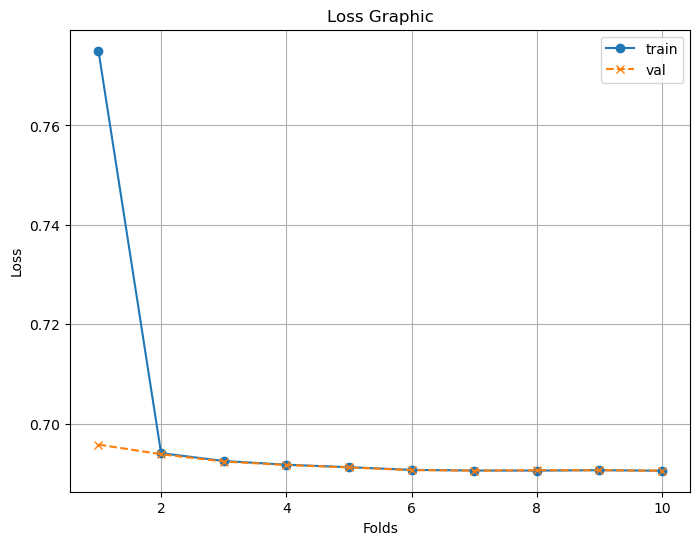

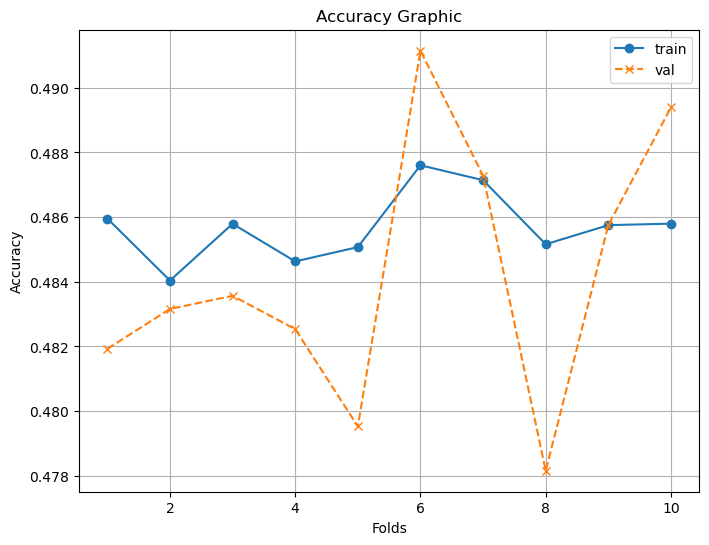

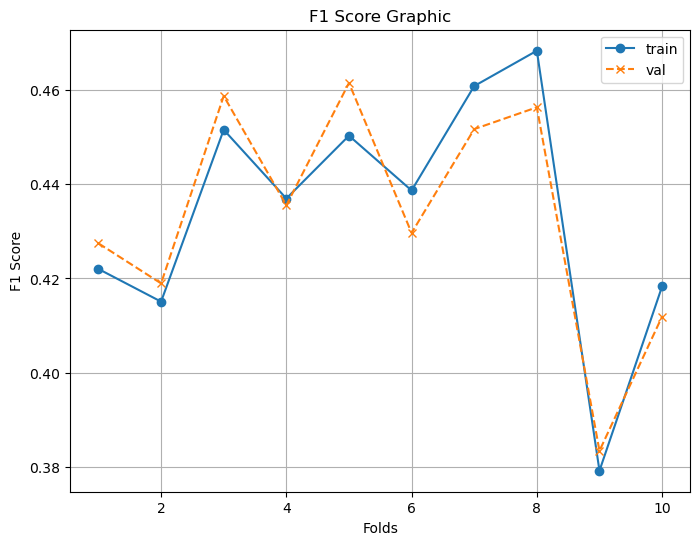

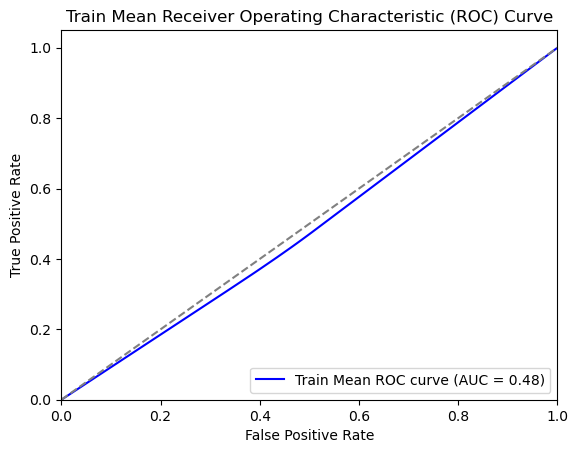

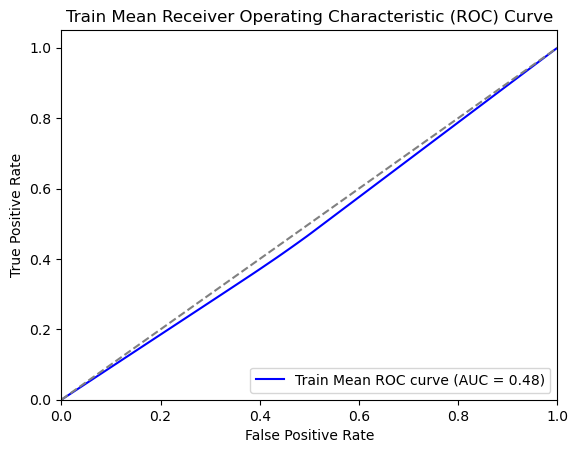

In [80]:
plot_eval_metric('Loss',losses,val_losses)
plot_eval_metric('Accuracy',accuracies,val_accuracies)
plot_eval_metric('F1 Score',f1_scores,val_f1_scores)

mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plot_roc_auc_curve('Train', mean_tpr, mean_auc, mean_fpr)

val_mean_tpr = np.mean(val_tprs, axis=0)
val_mean_auc = auc(val_mean_fpr, val_mean_tpr)
plot_roc_auc_curve('Train', val_mean_tpr, val_mean_auc, val_mean_fpr)

In [81]:
test_predict = np.round(model.predict(X_test))

834/834 [==============================] - 1s 2ms/step


In [82]:
accuracy = accuracy_score(y_test, test_predict)
accuracy

0.4918315347721823

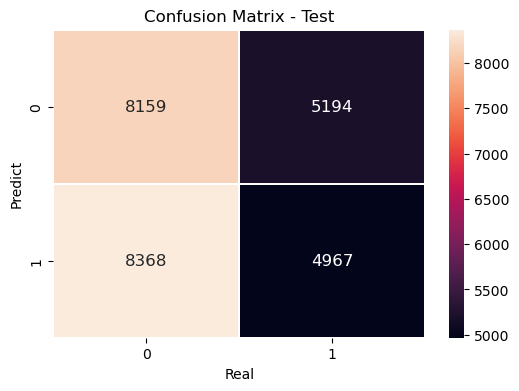

In [83]:
test_conf_matrix = confusion_matrix(y_test, test_predict)
plot_confunsion_matrix(test_conf_matrix, 'Test')